In [258]:
import numpy as np
import matplotlib.pyplot as plt

import random

from scipy import signal


import  matplotlib.animation

from matplotlib import animation

from IPython.display import HTML
def plot_images(img_list, fr=100):
    
  def init():
    img.set_data(img_list[0])
    return (img,)

  def animate(i):
    img.set_data(img_list[i])
    return (img,)

  fig = plt.figure()
  ax = fig.gca()
  plt.axis('off')
  img = ax.imshow(img_list[0])

  anim = animation.FuncAnimation(fig,
                                 animate, 
                                 init_func=init,
                                 frames=len(img_list), 
                                 interval=fr, 
                                 blit=True)
  return anim

# use like this
#HTML(plot_images(imgs).to_html5_video())

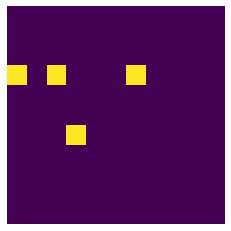

In [330]:
sz = 10

S = np.zeros((sz+1,sz+1),dtype=int)
S[:,0] = 1
S[0,:] += 2
S[sz,:] += 4
S[:,sz] += 7


diffs = [[1,0],[0,1],[-1,0],[0,-1]]

nogo = {0: [], 
        1: [3], 2: [2], 7: [1], 4: [0],
        5: [0,3], 9: [1,2],
        3: [2,3], 11:[0,1]
}

moves = {x:  [ y for k,y in enumerate(diffs) if k not in  nogo[x]] for x in nogo}

G = np.zeros((sz+1,sz+1))

pts = [ np.array([k,k],dtype=int) for k in range(2,sz,2)]
             
frames = []
for _ in range(200):
    G = np.zeros((sz+1,sz+1))
    for pt in pts:
        G[tuple(pt)] = 1
        #print(tuple(pts),S[tuple(pts)])
    
        pt += random.choice(moves[S[tuple(pt)]])
    
    frames.append(np.copy(G))

HTML(plot_images(frames, fr=100).to_html5_video()) 


In [326]:
! ../.g

[master 534e451] web
 10 files changed, 40734 insertions(+), 329 deletions(-)
 create mode 100644 PROG/.ipynb_checkpoints/ProjetLabyrinthe-AlleyssonMathis-checkpoint.html
 create mode 100644 PROG/.ipynb_checkpoints/gui_experiments-checkpoint.ipynb
 create mode 100644 PROG/.ipynb_checkpoints/projects-checkpoint.html
 rename PROG/{Untitled3.ipynb => Untitled12.ipynb} (100%)
 delete mode 100644 PROG/Untitled4.ipynb
 delete mode 100644 PROG/Untitled9.ipynb
 create mode 100644 PROG/gui_experiments.ipynb
Counting objects: 8, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 197.79 KiB | 4.50 MiB/s, done.
Total 8 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   a190c61..534e451  master -> master


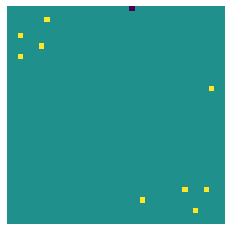

In [396]:
sz = 40
W =  np.zeros((sz+1,sz+1),dtype=int)
        #place the walls
W[:,0] = W[0,:] = W[sz,:] = W[:,sz] = 1
        

        # make a kernel
K = [0,1,0,2,0,8,0,4,0]
K = np.array(K).reshape(3,3)

        #these are the forbidden transitions for the states
forbidden = {0: [], 
                8: [3], 4: [2], 2: [1], 1: [0],
                9: [0,3], 6: [1,2],
                12: [2,3], 3:[0,1]
        }


        # calculate the states for the grid
X = signal.convolve2d( W, K)[2:-2,2:-2]

        #apparently these get cast to np.array when I add???
diffs = [[1,0],[0,1],[-1,0],[0,-1]]

allowed_moves = {}
for x in forbidden:
    allowed_moves[x] =  [ y for k,y in enumerate(diffs)
                                     if k not in  forbidden[x]] 
    
def get_move( pos):
    #globals i snot good
    return random.choice(allowed_moves[X[pos]])
        
        

G = np.zeros((sz+1,sz+1)) + 6
#initial configuration
pts = np.array([ np.array([k, k],dtype=int) for k in range(2, sz, 4)])
cols = np.array([ k%8 + 1 for k in range(2, sz, 4)])
             
frames = []
for _ in range(200):
    G = np.zeros((sz+1,sz+1)) + 5
    for pt,col in zip(pts,cols):
        pos = tuple(pt[:2])
        G[pos] = col
        pt += get_move(pos)
    
    # this is a bit of a hack to reduce computations
    Z = scipy.spatial.distance_matrix(pts[cols==3], pts[cols==7], p=np.infty)
    uninfected = np.where(cols==3)[0]
    uninfected_collisions = uninfected[np.any(Z < .5, axis = 1)]
    cols[uninfected_collisions ] = 7
    
    frames.append(np.copy(G))

HTML(plot_images(frames, fr=100).to_html5_video()) 


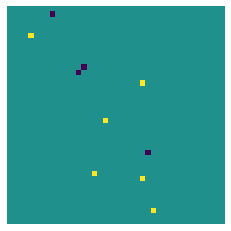

In [397]:

class Grid():
    
    def __init__(self, sz = 40):
        self.sz = sz
        W =  np.zeros((sz+1,sz+1),dtype=int)
        #place the walls
        W[:,0] = W[0,:] = W[sz,:] = W[:,sz] = 1
        self.W = W
        
        # make a kernel
        K = [0,1,0,2,0,8,0,4,0]
        K = np.array(K).reshape(3,3)

        #these are the forbidden transitions for the states
        forbidden = {0: [], 
                8: [3], 4: [2], 2: [1], 1: [0],
                9: [0,3], 6: [1,2],
                12: [2,3], 3:[0,1]
        }


        # calculate the states for the grid
        self.X = signal.convolve2d( W, K)[2:-2,2:-2]

        #apparently these get cast to np.array when I add???
        diffs = [[1,0],[0,1],[-1,0],[0,-1]]

        allowed_moves = {}
        for x in forbidden:
            allowed_moves[x] =  [ y for k,y in enumerate(diffs)
                                     if k not in  forbidden[x]] 
        self.allowed_moves = allowed_moves
    
    def get_move(self, pos):
        return random.choice(self.allowed_moves[self.X[pos]])
        
        
GG = Grid()      
            
G = np.zeros((sz+1,sz+1)) + 6
#initial configuration
pts = np.array([ np.array([k, k],dtype=int) for k in range(2, sz, 4)])
cols = np.array([ k%8 + 1 for k in range(2, sz, 4)])
             
frames = []
for _ in range(200):
    G = np.zeros((sz+1,sz+1)) + 5
    for pt,col in zip(pts,cols):
        pos = tuple(pt[:2])
        G[pos] = col
        pt += GG.get_move(pos)
    
    # this is a bit of a hack to reduce computations
    Z = scipy.spatial.distance_matrix(pts[cols==3], pts[cols==7], p=np.infty)
    uninfected = np.where(cols==3)[0]
    uninfected_collisions = uninfected[np.any(Z < .5, axis = 1)]
    cols[uninfected_collisions ] = 7
    
    frames.append(np.copy(G))

HTML(plot_images(frames, fr=100).to_html5_video()) 


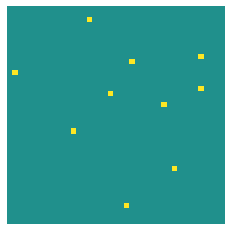

In [412]:
def valid(x):
    if x < 0 : return 0
    if x > sz :return sz
    return x

GG = Grid()      
            
G = np.zeros((sz+1,sz+1)) + 6
#initial configuration
pts = np.array([ np.array([k, k],dtype=int) for k in range(2, sz, 4)])
cols = np.array([ k%8 + 1 for k in range(2, sz, 4)])
             
frames = []
for _ in range(200):
    G = np.zeros((sz+1,sz+1)) + 5
    for pt,col in zip(pts,cols):
        pos = tuple(pt[:2])
        G[pos] = col
        pt += GG.get_move(pos)
        
    for _ in np.where(cols == 3)[0]:
        x,y = pts[_]
        nbs = G[valid(x-1):valid(x+2),valid(y-1):valid(y+2) ]
        if np.max(nbs) > 5:
            cols[_] = 7
 
    
 
    frames.append(np.copy(G))

HTML(plot_images(frames, fr=100).to_html5_video()) 


In [409]:
nbs

array([[5., 3.],
       [5., 5.]])

In [411]:
X[2:2:4]

array([[0, 0],
       [0, 0]])

In [336]:
cols

[3, 1, 3, 1, 3, 1, 3, 1, 3]

In [252]:
X


array([[12,  4,  4,  6],
       [ 8,  0,  0,  2],
       [ 8,  0,  0,  2],
       [ 9,  1,  1,  3]])

In [228]:
nogo = {0: [], 
        4: [3], 8: [2], 2: [1], 1: [0],
}

In [265]:
np.infty

inf

dict_keys([0, 4, 8, 2, 1])

In [236]:
K

array([[0, 1, 0],
       [2, 0, 4],
       [0, 8, 0]])